### 1. Import

In [1]:
import torch.nn as nn

class Net(nn.Module):
    """
    Convolutional Neural Network for PPO
    """

    def __init__(self, img_stack):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v


In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import numpy as np
from model import Net


img_stack=4

transition = np.dtype([('s', np.float64, (img_stack, 96, 96)), 
                       ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (img_stack, 96, 96))])

GAMMA=0.99
EPOCH= 8 # beter than 10
MAX_SIZE = 2000 ## CUDA out of mem for max_size=10000
BATCH=128 
EPS=0.1
LEARNING_RATE = 0.001 # bettr than 0.005 or 0.002 

class Agent():
    """ Agent for training """
    
    def __init__(self, device):
        self.training_step = 0
        self.net = Net(img_stack).double().to(device)
        self.buffer = np.empty(MAX_SIZE, dtype=transition)
        self.counter = 0
        self.device = device
        
        self.optimizer = optim.Adam(self.net.parameters(), lr=LEARNING_RATE)  ## lr=1e-3

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(self.device).unsqueeze(0)
        
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp


    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == MAX_SIZE:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(self.device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(self.device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(self.device).view(-1, 1)
        next_s = torch.tensor(self.buffer['s_'], dtype=torch.double).to(self.device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(self.device).view(-1, 1)

        with torch.no_grad():
            target_v = r + GAMMA * self.net(next_s)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(EPOCH):
            for index in BatchSampler(SubsetRandomSampler(range(MAX_SIZE)), BATCH, False):

                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                
                # clipped function
                surr2 = torch.clamp(ratio, 1.0 - EPS, 1.0 + EPS) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
# from agent import Agent, img_stack
import time
from collections import deque
import matplotlib
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

seed = 0 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

action_repeat = 10
env = gym.make('CarRacing-v2', verbose=0,render_mode='human')
state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)

device:  cpu
env.action_space.shape:  (3,)
reward_threshold 900


2024-11-29 16:22:44.607 python[96158:2182223] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-29 16:22:44.607 python[96158:2182223] +[IMKInputSession subclass]: chose IMKInputSession_Modern


### 2. Image Preprocessing

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


/opt/miniconda3/envs/myenv38/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


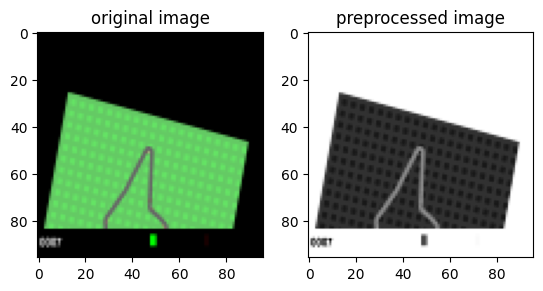

: 

In [ ]:
# show what a preprocessed image looks like
frame, _, _, _,_ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
    # Convert RGB to grayscale using the standard formula
    gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])  # RGB to grayscale
    if norm:
        # Normalize the grayscale image to range [-1, 1]
        gray = gray / 128.0 - 1.0
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

### 2. Class  Wrapper

In [ ]:
# class Wrapper():
#     """
#     Environment wrapper for CarRacing 
#     """

#     def __init__(self, env):
#         self.env = env  

#     # def reset(self):
#     #     self.counter = 0
#     #     self.av_r = self.reward_memory()

#     #     self.die = False
#     #     img_rgb = env.reset()
#     #     img_gray = rgb2gray(img_rgb)
#     #     self.stack = [img_gray] * img_stack  # four frames for decision
#     #     return np.array(self.stack)
#     def reset(self):
#         self.counter = 0
#         self.die = False
#         img_rgb, _ = self.env.reset()  # Reset environment and get initial image (ignore the info)
#         img_gray = rgb2gray(img_rgb)  # Convert to grayscale
#         self.stack = [img_gray] * img_stack  # Stack the initial frames
#         return np.array(self.stack)

#     def step(self, action):
#         total_reward = 0
#         for i in range(action_repeat):
#             img_rgb, reward, die, _, _ = env.step(action)
#             # don't penalize "die state"
#             if die:
#                 reward += 100
#             # green penalty
#             if np.mean(img_rgb[:, :, 1]) > 185.0:
#                 reward -= 0.05
#             total_reward += reward
#             # if no reward recently, end the episode
#             done = True if self.av_r(reward) <= -0.1 else False
#             if done or die:
#                 break
#         img_gray = rgb2gray(img_rgb)
#         self.stack.pop(0)
#         self.stack.append(img_gray)
#         assert len(self.stack) == img_stack
#         return np.array(self.stack), total_reward, done, die


#     @staticmethod
#     def reward_memory():
#         # record reward for last 100 steps
#         count = 0
#         length = 100
#         history = np.zeros(length)

#         def memory(reward):
#             nonlocal count
#             history[count] = reward
#             count = (count + 1) % length
#             return np.mean(history)

#         return memory



# class Wrapper:
#     """
#     Environment wrapper for CarRacing
#     """

#     def __init__(self, env, img_stack=4, action_repeat=4):
#         self.env = env
#         self.img_stack = img_stack
#         self.action_repeat = action_repeat
#         self.counter = 0
#         self.die = False
#         self.stack = []
#         self.av_r = self.reward_memory()  # Initialize reward memory function

#     def reset(self):
#         self.counter = 0
#         self.die = False
#         img_rgb, _ = self.env.reset()  # Reset environment and get initial image (ignore the info)
#         img_gray = rgb2gray(img_rgb)  # Convert to grayscale
#         self.stack = [img_gray] * self.img_stack  # Stack the initial frames
#         return np.array(self.stack)

#     def step(self, action):
#         total_reward = 0
#         for i in range(self.action_repeat):
#             action[0] = np.clip(action[0], -1.0, 1.0)  # Steering (-1 to 1)
#             action[1] = np.clip(action[1], 0.0, 1.0)   # Gas (0 to 1)
#             action[2] = np.clip(action[2], 0.0, 1.0)   # Braking (0 to 1)
#             img_rgb, reward, done, truncated, info = self.env.step(action)
#             # don't penalize "die state"
#             if self.die:
#                 reward += 100
#             # green penalty
#             if np.mean(img_rgb[:, :, 1]) > 185.0:
#                 reward -= 0.05
#             total_reward += reward

#             # Calculate the rolling average of the reward using self.av_r
#             done = True if self.av_r(reward) <= -0.1 else False
#             if done or self.die:
#                 break
        
#         # Update the stack with the new frame
#         img_gray = rgb2gray(img_rgb)
#         self.stack.pop(0)
#         self.stack.append(img_gray)
#         assert len(self.stack) == self.img_stack
        
#         return np.array(self.stack), total_reward, done, self.die

#     @staticmethod
#     def reward_memory():
#         # Record reward for the last 100 steps
#         count = 0
#         length = 100
#         history = np.zeros(length)

#         def memory(reward):
#             nonlocal count
#             history[count] = reward
#             count = (count + 1) % length
#             return np.mean(history)

#         return memory


class Wrapper:
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, env, img_stack=4, action_repeat=4):
        self.env = env
        self.img_stack = img_stack
        self.action_repeat = action_repeat
        self.die = False
        self.stack = []
        self.av_r = self.reward_memory()

    def reset(self):
        self.counter = 0
        self.die = False
        img_rgb, _ = self.env.reset()  # Correct unpacking
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * self.img_stack  # Stack the initial frames
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for _ in range(self.action_repeat):  # Loop for action repeats
            action[0] = np.clip(action[0], -1.0, 1.0)  # Steering (-1 to 1)
            action[1] = np.clip(action[1], 0.0, 1.0)   # Gas (0 to 1)
            action[2] = np.clip(action[2], 0.0, 1.0)   # Braking (0 to 1)
            img_rgb, reward, done, truncated, info = self.env.step(action)

            # Apply penalties and rewards
            if self.die:
                reward += 100
            if np.mean(img_rgb[:, :, 1]) > 185.0:  # Green penalty
                reward -= 0.05

            total_reward += reward

            # Calculate rolling average reward to decide on episode termination
            done = True if self.av_r(reward) <= -0.1 else done
            if done or self.die:
                break

        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == self.img_stack

        return np.array(self.stack), total_reward, done, self.die

    @staticmethod
    def reward_memory():
        # Record reward for the last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory


In [ ]:
def save(agent, directory, filename, suffix):
    torch.save(agent.net.state_dict(), '%s/%s_%s.pth' % (directory, filename, suffix))    

### 2. Train Agent

In [ ]:
agent = Agent(device)

env_wrap = Wrapper(env)

limits = [200, 400, 600, 800, 830, 870, 900]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf           


def ppo_train(n_episodes=5, save_every=500):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    i_lim = 0
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrap.step( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode if more than save_every=500 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            suf = return_suffix(avg_score)
            save(agent, '/Applications/Files/SEM_7/MAJOR/RL/model', 'model_weights', suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break
            
    return scores_array, avg_scores_array    
            
scores, avg_scores  = ppo_train()            

In [ ]:
save(agent, '/Applications/Files/SEM_7/MAJOR/RL/model', 'model_weights', '902')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
env.close()

In [ ]:
# import gymnasium as gym
# from stable_baselines3 import PPO

# # Create CarRacing environment
# env = gym.make('CarRacing-v2')

# # Initialize PPO with a CNN policy (since the input is images)
# # model = PPO('CnnPolicy', env, verbose=1,device='mps')
# model = PPO('CnnPolicy', env, verbose=1, device='mps', use_sde=True)


# # Train the model
# model.learn(total_timesteps=1000000)

# # Save the model
# model.save("ppo_car_racing")


In [ ]:
import os
# Load Model
def load(agent, directory, filename):
    model_path = os.path.join(directory, filename)
    agent.net.load_state_dict(torch.load(model_path))

# Play Function
from collections import deque

def play(env, agent, n_episodes):
    state = env_wrap.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes + 1):
        state = env_wrap.reset()        
        score = 0
        time_start = time.time()
        
        while True:
            # Select action from the agent
            action, a_logp = agent.select_action(state)
            env.render()

            # Take a step in the wrapped environment
            next_state, reward, done, die = env_wrap.step(
                action * np.array([2.0, 1.0, 1.0]) + np.array([-1.0, 0.0, 0.0])
            )

            state = next_state
            score += reward
            
            if done or die:
                break

        # Record time and performance
        elapsed_time = int(time.time() - time_start)
        scores_deque.append(score)
        scores.append(score)

        print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}, '
              f'\tScore: {score:.2f} \tTime: {elapsed_time // 3600:02}:{elapsed_time % 3600 // 60:02}:{elapsed_time % 60:02}')
    
    return scores

# # Play Scenarios
# load(agent, 'dir_chk', 'model_weights_350-550.pth')
# play(env, agent, n_episodes=5)

# load(agent, 'dir_chk', 'model_weights_480-660.pth')
# play(env, agent, n_episodes=5)

load(agent, '/Applications/Files/SEM_7/MAJOR/RL/model', 'model_weights_800.pth')
play(env, agent, n_episodes=5)

# Close the environment
env.close()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV
data = pd.read_csv('/Applications/Files/SEM_7/MAJOR/RL/data/scores_data.csv')

# Extract columns
episodes = data['Episode']
scores = data['Score']
avg_scores = data['Avg_Score_100']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes, scores, label='Episode Score', color='blue', alpha=0.7)
plt.plot(episodes, avg_scores, label='Running Average (100)', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episode Scores and Running Average')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV
data = pd.read_csv('/Applications/Files/SEM_7/MAJOR/RL/data/scores_data.csv')


# Extract columns
episodes = data['Episode']
scores = data['Score']

# Compute EWMA (Exponentially Weighted Moving Average)
alpha = 0.1  # Smoothing factor (adjust as needed)
ewma_scores = scores.ewm(alpha=alpha).mean()


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes, scores, label='Episode Score', color='blue', alpha=0.6)
plt.plot(episodes, ewma_scores, label=f'EWMA (α={alpha})', color='red', linestyle='dashed')

# Add labels, title, and legend
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episode Scores and EWMA')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
